# Amazone Fine Food Review Analysis 

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

   Number of reviews: 568,454<br>
   Number of users: 256,059<br>
   Number of products: 74,258<br>
   Timespan: Oct 1999 - Oct 2012<br>
   Number of Attributes/Columns in data: 10 

Attribute Information:

   1. Id
   2. ProductId - unique identifier for the product
   3. UserId - unqiue identifier for the user
   4. ProfileName
   5. HelpfulnessNumerator - number of users who found the review helpful
   6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
   7. Score - rating between 1 and 5
   8. Time - timestamp for the review
   9. Summary - brief summary of the review
   10. Text - text of the review



In [29]:
#import re
#import string
import pickle
import sqlite3
import pandas as pd
import numpy as np
from sklearn.cross_validation import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.model_selection import  TimeSeriesSplit
from datetime import datetime
from sklearn.metrics import classification_report
import seaborn as sns
import scikitplot.metrics as skplt
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import metrics
from sklearn.metrics import roc_curve,auc
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from sklearn.model_selection import GridSearchCV
import gensim
import warnings
warnings.filterwarnings("ignore")
from tqdm import tqdm
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
import graphviz
from sklearn import tree

## Loading Data

In [14]:
con = sqlite3.connect("final.sqlite")
final = pd.read_sql_query("""SELECT * FROM Reviews""",con)

## Sorting data 

In [15]:
final.sort_values("Time",ascending=True, inplace=True, kind='quicksort')

##### Replace Negative with 0 and Positive with 1 

In [16]:
final['Score'].replace(['negative', 'positive'],[0,1],inplace=True)

In [17]:
final = final.to_csv("final.csv") #saving dataframe

In [30]:
final = pd.read_csv("final.csv") #retriving the sorted dataframe

In [31]:
final = final.iloc[:100000] #taking initial 100k points

## Function

In [32]:
# defining model function that does cross validation ,plot  accuracy, test accuracy and confusion matrix
# this function takes 'search', 'X_train', 'X_test', 'y_train', 'y_test' as arguments

def DT(scoring,X_train, X_test, y_train, y_test,n):
    
    
    start=datetime.now()
  
    cv_score=[]
    
    depth=list(range(1,n))
    param={'max_depth':depth}
    tscv=TimeSeriesSplit(n_splits=10)
    DT=DecisionTreeClassifier()
    clf=GridSearchCV(estimator=DT, param_grid=param, scoring=scoring, n_jobs=-1, cv=tscv, verbose=1)
    clf.fit(X_train,y_train)
    
    optimal_depth=clf.best_estimator_.get_params()['max_depth']
    print('optimal depth',optimal_depth)
    
    if (scoring == "f1"):
        # finding precision error and optimal depth
        mse=[]
        for x in clf.grid_scores_:
            mse.append(x[1])
    
        #ploting f1_score vs depth
        plt.figure(figsize=(8,8))
        plt.plot(depth,mse)
        plt.xlabel('depth')
        plt.ylabel('F1_score')
        plt.title('plot between depth vs F1_score ')
        plt.show()
    
    elif (scoring == "accuracy"):
        mse=[]
        for x in clf.grid_scores_:
            mse.append(1-x[1])
    
        #ploting precision error vs depth
        plt.figure(figsize=(8,8))
        plt.plot(depth,mse)
        plt.xlabel('depth')
        plt.ylabel('misclassification error')
        plt.title('plot between depth vs error')
        plt.show()
   

    #Testing Accuracy on Test data
    DT=DecisionTreeClassifier(max_depth = optimal_depth)
    DT.fit(X_train,y_train)
    y_pred = DT.predict(X_test)
    print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
    print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred)))
    print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred)))
    print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))
    print("Confusion Matrix of test set:\n [ [TN  FP]\n [FN TP] ]\n")
    
    confusion = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
    sns.set(font_scale=1.4)#for label size
    sns.heatmap(confusion, annot=True,annot_kws={"size": 16}, fmt='g')
    #skplt.plot_confusion_matrix(y_test ,y_pred)
    
    end=datetime.now()
    print('duration = ',(end-start))
    
    return optimal_depth

## 1.Bag Of Word 

   The bag-of-words model is a simplifying representation used in natural language processing and information retrieval(IR).Also known as the vector space model.The bag-of-words model is commonly used in methods of document classification where the occurrence of each word is used as a feature for training a classifier.OR
   Simply,Converting a collection of text documents to a matrix of token counts

In [33]:
X = final["CleanedText"] #taking cleandtext as X
y = final["Score"] #taking score as y

## 1.1  BOW with Scoring = F1

Train Data Size:  (70000, 31377)
Test Data Size:  (30000, 31377)
Fitting 10 folds for each of 29 candidates, totalling 290 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 160 tasks      | elapsed:   19.1s
[Parallel(n_jobs=-1)]: Done 290 out of 290 | elapsed:  1.1min finished


optimal depth 10


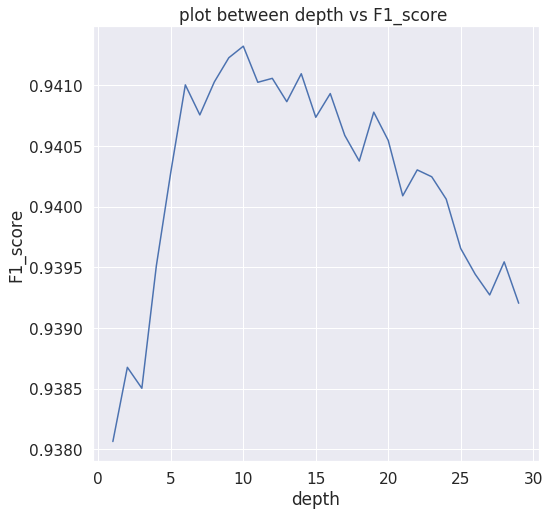

Accuracy on test set: 87.877%
Precision on test set: 0.887
Recall on test set: 0.984
F1-Score on test set: 0.933
Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]

duration =  0:01:09.809414


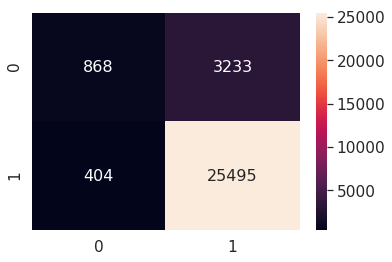

In [34]:
#Breaking into Train and test
X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=0.7,shuffle=False,random_state=0)

#Bag of Words
count = CountVectorizer() 

X_train = count.fit_transform(X_train)

X_test = count.transform(X_test)

print ("Train Data Size: ",X_train.shape)
print ("Test Data Size: ",X_test.shape)

depth = DT(scoring="f1",X_train = X_train, X_test=X_test, y_train=y_train, y_test=y_test,n=30)


## 1.1.1  feature importance

In [35]:
#feature importance
clf=DecisionTreeClassifier(max_depth=depth)
clf.fit(X_train,y_train)
print('top 25 words and their IG---')
print('---------------------------------')
top=clf.feature_importances_
s=np.argsort(top)[-25:]
feature=count.get_feature_names()
for i in range(25):
    index=s[i]
    print(feature[index],'\t\t:\t\t',round(top[index],5))

top 25 words and their IG---
---------------------------------
first 		:		 0.00356
use 		:		 0.00358
flavor 		:		 0.00388
item 		:		 0.00394
noth 		:		 0.00409
back 		:		 0.00453
ive 		:		 0.0053
good 		:		 0.00562
aw 		:		 0.00566
unfortun 		:		 0.00783
threw 		:		 0.00853
refund 		:		 0.01183
delici 		:		 0.01616
wont 		:		 0.01873
wast 		:		 0.03371
bad 		:		 0.03982
return 		:		 0.04224
horribl 		:		 0.05279
love 		:		 0.05427
terribl 		:		 0.05487
money 		:		 0.06344
best 		:		 0.06866
worst 		:		 0.08066
great 		:		 0.09007
disappoint 		:		 0.15119


### Observation
* we can take depth 10 as best hyperparameter

## 1.2 BOW with Scoring = "accuracy"

Train Data Size:  (70000, 31377)
Test Data Size:  (30000, 31377)
Fitting 10 folds for each of 29 candidates, totalling 290 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 160 tasks      | elapsed:   18.9s
[Parallel(n_jobs=-1)]: Done 290 out of 290 | elapsed:  1.1min finished


optimal depth 10


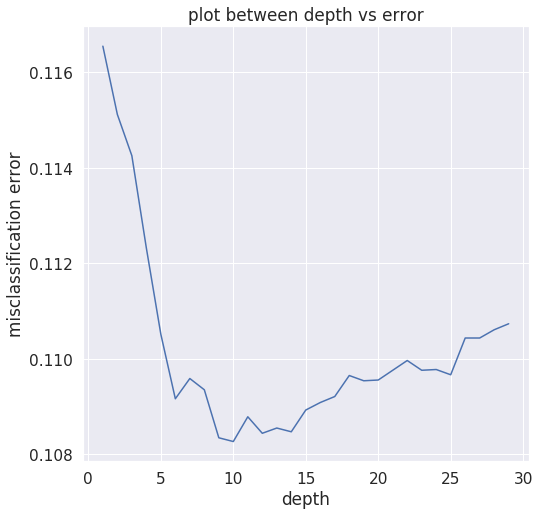

Accuracy on test set: 87.923%
Precision on test set: 0.888
Recall on test set: 0.985
F1-Score on test set: 0.934
Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]

duration =  0:01:10.056800


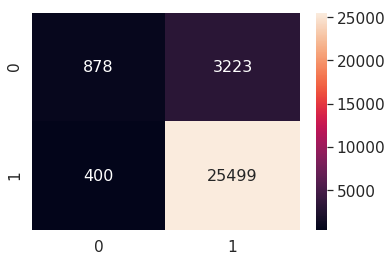

In [36]:
print ("Train Data Size: ",X_train.shape)
print ("Test Data Size: ",X_test.shape)

depth = DT(scoring="accuracy",X_train = X_train, X_test=X_test, y_train=y_train, y_test=y_test,n=30)


## 1.2.1  feature importance

In [37]:
#feature importance
clf=DecisionTreeClassifier(max_depth=depth)
clf.fit(X_train,y_train)
print('top 25 words and their IG---')
print('---------------------------------')
top=clf.feature_importances_
s=np.argsort(top)[-25:]
feature=count.get_feature_names()
for i in range(25):
    index=s[i]
    print(feature[index],'\t\t:\t\t',round(top[index],5))

top 25 words and their IG---
---------------------------------
first 		:		 0.00356
use 		:		 0.00358
flavor 		:		 0.00388
item 		:		 0.00394
noth 		:		 0.00409
back 		:		 0.00453
ive 		:		 0.0053
good 		:		 0.00562
aw 		:		 0.00566
unfortun 		:		 0.00783
threw 		:		 0.00853
refund 		:		 0.01183
delici 		:		 0.01616
wont 		:		 0.01873
wast 		:		 0.03371
bad 		:		 0.03985
return 		:		 0.04224
horribl 		:		 0.05279
terribl 		:		 0.05487
love 		:		 0.05514
money 		:		 0.06345
best 		:		 0.06769
worst 		:		 0.08066
great 		:		 0.09001
disappoint 		:		 0.15119


### Observation
* we can take depth 10 as best hyperparameter

### 1.3 Tree

In [38]:
clf=DecisionTreeClassifier(max_depth=depth)
clf.fit(X_train,y_train)
dot_data = tree.export_graphviz(clf, out_file=None) 
graph = graphviz.Source(dot_data) 
graph.render("graph_bow")

'graph_bow.pdf'

## 2.TFIDF

### 2.1 TFDIF with Scoring = F1

Train Data Size:  (70000, 31377)
Test Data Size:  (30000, 31377)
Fitting 10 folds for each of 29 candidates, totalling 290 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 160 tasks      | elapsed:   25.9s
[Parallel(n_jobs=-1)]: Done 290 out of 290 | elapsed:  1.4min finished


optimal depth 11


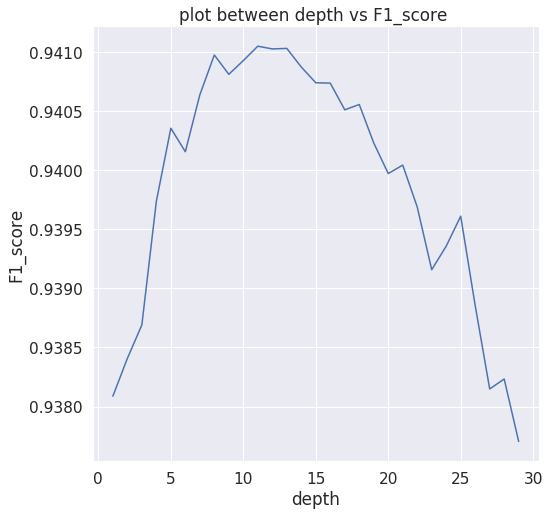

Accuracy on test set: 87.947%
Precision on test set: 0.890
Recall on test set: 0.981
F1-Score on test set: 0.934
Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]

duration =  0:01:36.422260


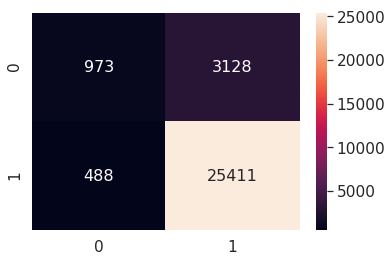

In [39]:
#Breaking into Train and test
X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=0.7,shuffle=False,random_state=0)

tfidf = TfidfVectorizer(ngram_range=(1,1), binary=True)

X_train = tfidf.fit_transform(X_train)

X_test = tfidf.transform(X_test)

print ("Train Data Size: ",X_train.shape)
print ("Test Data Size: ",X_test.shape)


depth = DT(scoring="f1",X_train = X_train, X_test=X_test, y_train=y_train, y_test=y_test,n=30)

## 1.2.1  feature importance

In [40]:
#feature importance
clf=DecisionTreeClassifier(max_depth=depth)
clf.fit(X_train,y_train)
print('top 25 words and their IG---')
print('---------------------------------')
top=clf.feature_importances_
s=np.argsort(top)[-25:]
feature=tfidf.get_feature_names()
for i in range(25):
    index=s[i]
    print(feature[index],'\t\t:\t\t',round(top[index],5))

top 25 words and their IG---
---------------------------------
ever 		:		 0.00424
unfortun 		:		 0.00425
amazon 		:		 0.00434
thought 		:		 0.00458
order 		:		 0.00476
perfect 		:		 0.00511
tasti 		:		 0.00588
mayb 		:		 0.00968
horribl 		:		 0.00982
threw 		:		 0.01177
tast 		:		 0.01492
delici 		:		 0.01547
wont 		:		 0.01777
money 		:		 0.0277
return 		:		 0.03589
love 		:		 0.04164
bad 		:		 0.04179
terribl 		:		 0.04399
refund 		:		 0.04979
aw 		:		 0.05244
best 		:		 0.05508
wast 		:		 0.05834
great 		:		 0.07711
worst 		:		 0.08169
disappoint 		:		 0.1425


### Observation
* we can take depth 11 as best hyperparameter

## 2.2 TFDIF with Scoring = "accuracy"

Train Data Size:  (70000, 31377)
Test Data Size:  (30000, 31377)
Fitting 10 folds for each of 29 candidates, totalling 290 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 160 tasks      | elapsed:   25.9s
[Parallel(n_jobs=-1)]: Done 290 out of 290 | elapsed:  1.4min finished


optimal depth 14


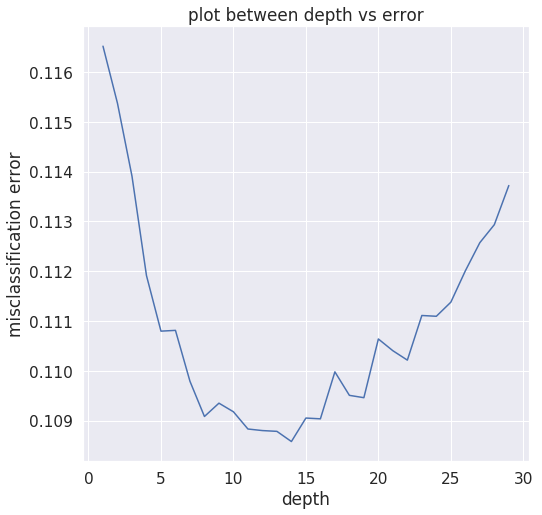

Accuracy on test set: 87.893%
Precision on test set: 0.891
Recall on test set: 0.980
F1-Score on test set: 0.933
Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]

duration =  0:01:41.241411


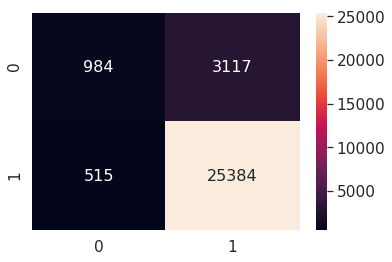

In [41]:
print ("Train Data Size: ",X_train.shape)
print ("Test Data Size: ",X_test.shape)

depth = DT(scoring="accuracy",X_train = X_train, X_test=X_test, y_train=y_train, y_test=y_test,n=30)


## 1.2.1  feature importance

In [42]:
#feature importance
clf=DecisionTreeClassifier(max_depth=depth)
clf.fit(X_train,y_train)
print('top 25 words and their IG---')
print('---------------------------------')
top=clf.feature_importances_
s=np.argsort(top)[-25:]
feature=tfidf.get_feature_names()
for i in range(25):
    index=s[i]
    print(feature[index],'\t\t:\t\t',round(top[index],5))

top 25 words and their IG---
---------------------------------
box 		:		 0.00477
good 		:		 0.00576
amazon 		:		 0.00582
order 		:		 0.00605
tasti 		:		 0.00629
unfortun 		:		 0.00633
mayb 		:		 0.00696
threw 		:		 0.00948
tast 		:		 0.01295
wont 		:		 0.01347
would 		:		 0.02167
money 		:		 0.02265
return 		:		 0.02892
horribl 		:		 0.03286
bad 		:		 0.03367
delici 		:		 0.03377
terribl 		:		 0.03544
love 		:		 0.03679
refund 		:		 0.04053
aw 		:		 0.04225
best 		:		 0.04438
wast 		:		 0.04812
great 		:		 0.06284
worst 		:		 0.0667
disappoint 		:		 0.11529


### Observation
* we can take depth 14 as best hyperparameter

### 2.2 Tree

In [43]:
clf=DecisionTreeClassifier(max_depth=13)
clf.fit(X_train,y_train)
dot_data = tree.export_graphviz(clf, out_file=None,) 
graph = graphviz.Source(dot_data) 
graph.render("graph_tfidf")

'graph_tfidf.pdf'

 ## 3.AVG WORD2VEC

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=0.7,shuffle=False,random_state=0)

In [45]:
# Train your own Word2Vec model using your own text corpus
#for train data
i=0
list_of_sent=[]
for sent in X_train.values:
    list_of_sent.append(sent.split())

In [46]:
w2v_model=gensim.models.Word2Vec(list_of_sent,min_count=5,size=300, workers=4)   

In [47]:
w2v_words_train = list(w2v_model.wv.vocab)

In [48]:
words_train = list(w2v_model.wv.vocab)
print(len(words_train))

10700


In [49]:
i=0
list_of_sent_test=[]
for sent in X_test.values:
    list_of_sent_test.append(sent.split())

In [50]:
w2v_model_test=gensim.models.Word2Vec(list_of_sent_test,min_count=5,size=300, workers=4)   

In [51]:
w2v_words_test = list(w2v_model_test.wv.vocab)

In [52]:
words_test = list(w2v_model_test.wv.vocab)
print(len(words_test))

7363


# AVG W2V

In [53]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words_train:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

70000
300


In [54]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent_test: # for each review/sentence
    sent_vec = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word_test in sent: # for each word in a review/sentence
        if word in words_test:
            vec = w2v_model_test.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
print(len(sent_vectors_test))
print(len(sent_vectors_test[0]))

30000
300


## 3.1 AVG W2V with Scoring = " f1"

Fitting 10 folds for each of 19 candidates, totalling 190 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   21.1s
[Parallel(n_jobs=-1)]: Done 190 out of 190 | elapsed:  6.4min finished


optimal depth 1


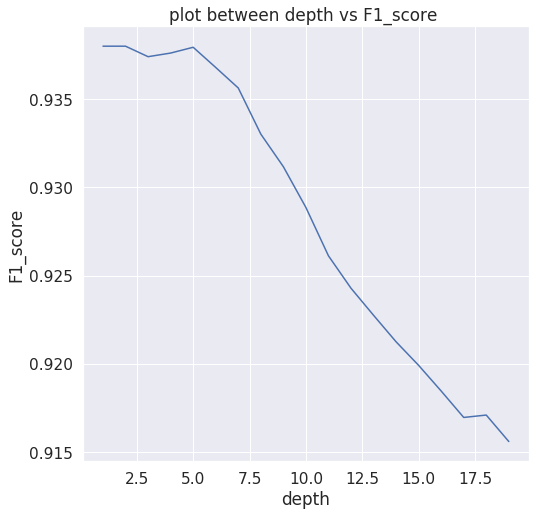

Accuracy on test set: 86.330%
Precision on test set: 0.863
Recall on test set: 1.000
F1-Score on test set: 0.927
Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]

duration =  0:06:34.133432


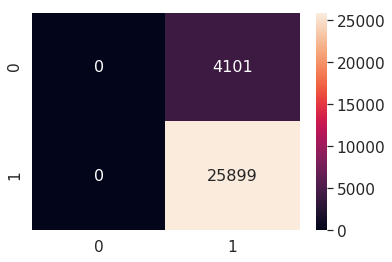

In [55]:
depth = DT(scoring="f1",n=20,X_train=sent_vectors, X_test=sent_vectors_test, y_train=y_train, y_test=y_test)


## 3.2 AVG W2V with Scoring =  "accuracy"

Fitting 10 folds for each of 19 candidates, totalling 190 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   20.7s
[Parallel(n_jobs=-1)]: Done 190 out of 190 | elapsed:  6.4min finished


optimal depth 5


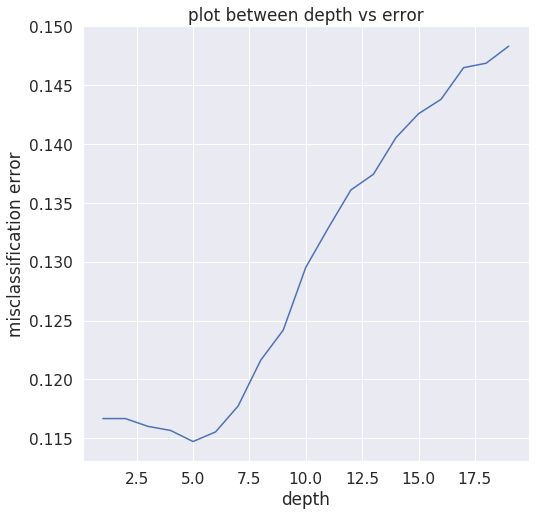

Accuracy on test set: 86.330%
Precision on test set: 0.863
Recall on test set: 1.000
F1-Score on test set: 0.927
Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]

duration =  0:07:03.226915


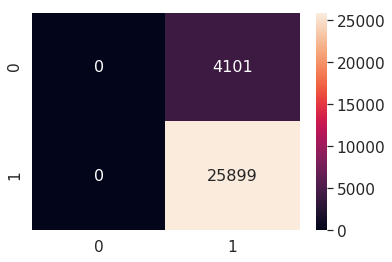

In [56]:
depth = DT(scoring="accuracy",n=20,X_train=sent_vectors, X_test=sent_vectors_test, y_train=y_train, y_test=y_test)

## 4. TFDIF WORD2VEC

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=0.7,shuffle=False,random_state=0)

In [58]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(X_train.values)
tfidf_idf_matrix_test = model.transform(X_test.values)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [59]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sent): # for each review/sentence 
    sent_vec = np.zeros(300) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word_train in sent: # for each word in a review/sentence
        if word in w2v_words_train:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1
    
print(len(tfidf_sent_vectors))
print(len(tfidf_sent_vectors[0]))

100%|██████████| 70000/70000 [02:50<00:00, 410.44it/s]

70000
300


In [60]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sent_test): # for each review/sentence 
    sent_vec = np.zeros(300) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word_test in sent: # for each word in a review/sentence
        if word in w2v_words_test:
            vec = w2v_model_test.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1
    
print(len(tfidf_sent_vectors_test))
print(len(tfidf_sent_vectors_test[0]))

100%|██████████| 30000/30000 [00:19<00:00, 1551.33it/s]

30000
300


### 4.1  TFDIF WORD2VEC with Scoring = "f1"

Fitting 10 folds for each of 29 candidates, totalling 290 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   18.6s
[Parallel(n_jobs=-1)]: Done 160 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 290 out of 290 | elapsed:  8.2min finished


optimal depth 1


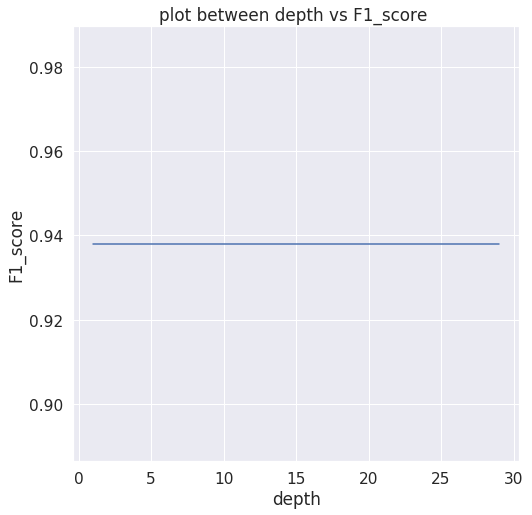

Accuracy on test set: 86.330%
Precision on test set: 0.863
Recall on test set: 1.000
F1-Score on test set: 0.927
Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]

duration =  0:08:13.867747


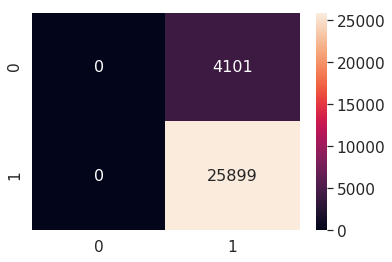

In [61]:
depth = DT(scoring="f1",n=30,X_train =tfidf_sent_vectors, X_test=tfidf_sent_vectors_test, y_train=y_train, y_test=y_test)

### 4.2 TFDIF WORD2VEC with Scoring = "accuracy"

Fitting 10 folds for each of 29 candidates, totalling 290 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   18.5s
[Parallel(n_jobs=-1)]: Done 160 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 290 out of 290 | elapsed:  8.2min finished


optimal depth 1


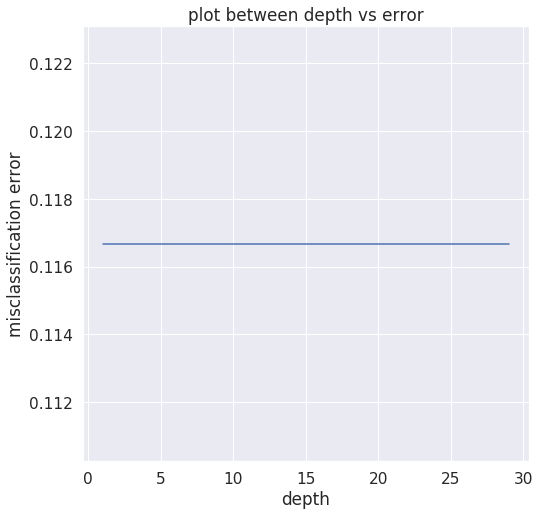

Accuracy on test set: 86.330%
Precision on test set: 0.863
Recall on test set: 1.000
F1-Score on test set: 0.927
Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]

duration =  0:08:13.446088


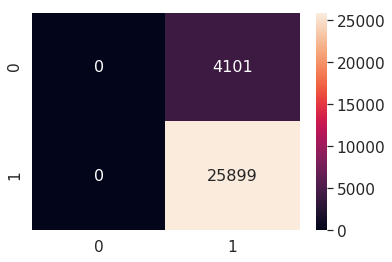

In [62]:
depth = DT(scoring="accuracy",n=30,X_train=tfidf_sent_vectors, X_test=tfidf_sent_vectors_test, y_train=y_train, y_test=y_test)

# Performance Table

| S No.|featurization | scoring | depth	 | accuracy | Precision | Recall | f1-score |
|------|--------------|---------|--------|----------|-----------|--------|----------|
|1|BOW|F1|10|87.877%|0.887|0.984|0.933|
|2|BOW|ACCURACY|10|87.923%|0.888|0.985|0.934|
|3|TFIDF|F1|11|87.947%|0.890|0.981|0.934|
|4|TFIDF|ACCURACY|14|87.893%|0.891|0.980|0.933|
|5|AVG W2V|F1|1|86.330%|0.863|1|0.927|
|6|AVG W2V|ACCURACY|5|86.330%|0.863|1|0.927|
|7|TFIDF W2V|F1|1|86.330%|0.863|1|0.927|
|8|TFIDF W2V|ACCURACY|1|86.330%|0.863|1|0.927|


## Conclusion-
* On appling DecisionTreeClassifier on amazon fine food review observe following conclusion.
* Standardization and normalization has no impact on the performance of a decision tree.
* we applied four featurization for Decision Tree.
* As we can see that recall is so bad especially in case of avg word2vec model and Tfidf word2vec model, seems like dumb model.
* depth of avg word2vec model and Tfidf word2vec model seem like overfit model.
* So we can conclude that decision tree is not working well for this amazon fine food review dataset.
